# Training Notebook for COMP9993 Thesis.

## Skeletal-Based Body Gesture Interaction With A Social Robot Companion

Written by Hongliang Sun.

#### Data Exploration, Cleanup, and Validation

We have five main classes, each of which has 50 data samples. Each data sample has 10 txt files which denote frames in time of the classes' gesture. 

In [ ]:
import os


def countFoldersRecursively(folder_path, level=0):
    # Get the folder name from the path
    folder_name = os.path.basename(folder_path)

    # Count the number of subfolders and .txt files in the current folder
    subfolders = next(os.walk(folder_path))[1]  # List of subdirectories
    files = [
        f for f in os.listdir(folder_path) if f.endswith(".txt")
    ]

    # Print the current folder name, subfolder count, and .txt file count
    indent = " " * (level * 4)
    print(f"{indent}{folder_name}/")
    print(f"{indent}  Subfolders: {len(subfolders)}, .txt Files: {len(files)}")

    # Recursively traverse each subfolder
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        countFoldersRecursively(subfolder_path, level + 1)

dataPath = "./3d_dataset"
countFoldersRecursively(dataPath)

To ensure that each file has the exact same number of datapoints so there are no inconsistencies, we will check it with the following script.

In [4]:
# This function ensures that all .txt files in the dataset have the correct number of lines (78 lines)
def checkFileLineCount(folder_path, required_lines=78):
    files_with_wrong_lines = []  # To store files that don't meet the line count

    # Recursively go through all subfolders and check each file
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    # Now check and store the actual line count for this file
                    if len(lines) != required_lines:
                        files_with_wrong_lines.append((file_path, len(lines)))

    # Output the result
    if not files_with_wrong_lines:
        print("-- All Files Meet the Required Line Count --")
    else:
        print("The following files do not have the required number of lines:")
        print(f"There are {len(files_with_wrong_lines)} files with wrong line count")
        print(f"-- Required: {required_lines} lines per file--")
        for file_path, line_count in files_with_wrong_lines:
            print(f"{file_path} has {line_count} lines (Expected: {required_lines})")


dataPath = "./2d_dataset"
checkFileLineCount(dataPath)

-- All Files Meet the Required Line Count --


In [ ]:
# This function is a check on the validity of mediapipe's extracted hand labels in the dataset. 
# It checks if each file has exactly one "Left Hand:" and one "Right Hand:" label.

def checkFileLineCountAndHandLabels(folder_path):
    files_with_wrong_lines = []
    files_with_hand_label_issues = ([])  # Files with more than one left or right hand

    # Recursively go through all subfolders and check each file
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    # Check for "Left Hand:" and "Right Hand:" occurrences
                    left_hand_count = sum(1 for line in lines if "Hand: Left" in line)
                    right_hand_count = sum(1 for line in lines if "Hand: Right" in line)

                    if left_hand_count != 1 or right_hand_count != 1:
                        files_with_hand_label_issues.append(
                            (file_path, left_hand_count, right_hand_count)
                        )

    if not files_with_hand_label_issues:
        print("All files contain exactly one 'Left Hand:' and one 'Right Hand:'.")
    else:
        print(f"There are {len(files_with_hand_label_issues)} files with issues:")
        print(
            "The following files have issues with 'Left Hand:' or 'Right Hand:' occurrences:"
        )
        for (
            file_path,
            left_hand_count,
            right_hand_count,
        ) in files_with_hand_label_issues:
            print(
                f"{file_path} has {left_hand_count} 'Left Hand:' and {right_hand_count} 'Right Hand:'"
            )


dataPath = "./3d_dataset"
checkFileLineCountAndHandLabels(dataPath)

In [ ]:
# This function will modify the dataset so Left Hand starts first, followed by Right Hand.
def swap_left_right_hand_if_needed(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Find indices where "Hand: Left", "Hand: Right", and "Body:" occur
    left_hand_start = None
    right_hand_start = None
    body_start = None

    for i, line in enumerate(lines):
        if "Hand: Left" in line:
            left_hand_start = i
        elif "Hand: Right" in line:
            right_hand_start = i
        elif "Body:" in line:
            body_start = i
            break

    # If "Hand: Right" occurs before "Hand: Left", swap the sections
    if (
        left_hand_start is not None
        and right_hand_start is not None
        and right_hand_start < left_hand_start
    ):
        # Extract Right Hand data
        right_hand_data = lines[right_hand_start : right_hand_start + 1]
        for i in range(right_hand_start + 1, len(lines)):
            if "Hand:" in lines[i] or "Body:" in lines[i]:
                break
            right_hand_data.append(lines[i])

        # Extract Left Hand data
        left_hand_data = lines[left_hand_start : left_hand_start + 1]
        for i in range(left_hand_start + 1, len(lines)):
            if "Hand:" in lines[i] or "Body:" in lines[i]:
                break
            left_hand_data.append(lines[i])

        # If body data exists, extract the body section
        body_data = lines[body_start:] if body_start else []

        # Replace the data in the correct order: Left Hand first, Right Hand second, Body at the end
        reordered_data = left_hand_data + right_hand_data + body_data

        # Write the reordered data back into the file
        with open(file_path, "w") as f:
            f.writelines(reordered_data)


def organize_files_in_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                swap_left_right_hand_if_needed(file_path)
                print(f"Processed {file_path}")


dataPath = "./3d_dataset"
organize_files_in_folder(dataPath)

Next, we will begin purging points that are of no little interest/significance in our task. This will involve the removal of landmarks, and the conversion of the remaining datapoints into tensors.

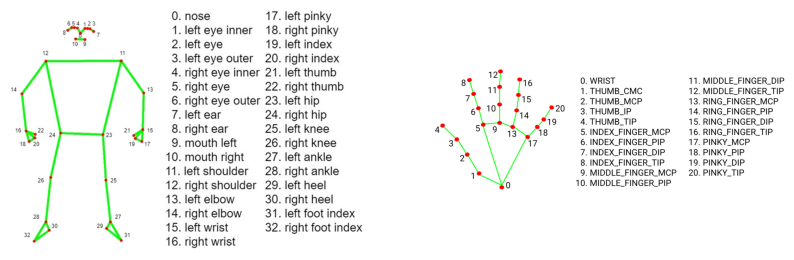

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread("./utils/body_landmarks.png")
img2 = mpimg.imread("./utils/hand_landmarks.png")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")

# Show the images
plt.show()

We will remove the following points from the following body landmarks. Refer above for corresponding part.

Body: [11 - 16 + 23 - 24]

[0 - 10] All face landmarks will be removed.
[11 - 16] Arm landmarks will be retained.
[15 - 22] All hand landmarks will be removed.
[23 - 24] Lower hip landmarks will be retained.
[25 - 32] All lower-hip landmarks will be removed.

Hand: All hand landmarks will be retained.

In [ ]:
def process_file(file_path):
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Step 1: Remove "Hand: Left", "Hand: Right", and "Body" tags
    cleaned_lines = [
        line
        for line in lines
        if "Hand: Left" not in line
        and "Hand: Right" not in line
        and "Body:" not in line
    ]

    # Step 2: Split the remaining lines into hand data and body data
    hand_data = cleaned_lines[:-33]  # All lines except the last 33 belong to the hands
    body_data = cleaned_lines[-33:]  # Last 33 lines are the body data

    # Step 3: Select specific body lines (11-16, 23, and 24)
    selected_body_lines = body_data[11:17] + [body_data[23], body_data[24]]

    # Step 4: Combine hand data and selected body lines
    final_data = hand_data + selected_body_lines

    # Step 5: Write the final data back to the file
    with open(file_path, "w") as f:
        f.writelines(final_data)

    print(f"Processed file: {file_path}")


def process_files_in_directory(directory_path):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith(".txt"):  # Only process .txt files
                file_path = os.path.join(root, file)
                process_file(file_path)


dataset_path = "./3d_dataset"
process_files_in_directory(dataset_path)

For 2d_dataset:

1. We will remove the z axis alltogether, this is very simple and can be done without much validation

In [ ]:
# def remove_depth_from_file(file_path):
#     with open(file_path, "r") as f:
#         lines = f.readlines()

#     def remove_depth(line):
#         values = line.split(",")
#         return f"{values[0].strip()}, {values[1].strip()}\n"
#     processed_lines = [remove_depth(line) for line in lines if line.strip()]
#     with open(file_path, "w") as f:
#         f.writelines(processed_lines)
#     print(f"Processed file: {file_path}")


# def process_files_in_directory(directory_path):
#     for root, dirs, files in os.walk(directory_path):
#         for file in files:
#             if file.endswith(".txt"):  
#                 file_path = os.path.join(root, file)
#                 remove_depth_from_file(file_path)


# dataset_path = "./dataset"
# process_files_in_directory(dataset_path)

In [ ]:
import numpy as np
import os
import random

def scale_points(points, depth_scale):
    # Rescale to give the illusion of depth complexity
    scaled_points = []
    for x, y in points:
        # Scale depth (y)
        new_y = y * depth_scale

        # Calculate scaling factor for x based on change in depth
        scale_ratio = new_y / y if y != 0 else 1
        new_x = x * scale_ratio

        scaled_points.append((new_x, new_y))

    return scaled_points

# Modify end_index to avoid overwriting existing folders, e.g., set to 100 to create new folders starting from 101
def apply_random_depth_scale_to_dataset(base_directory, scale_range=(0.3, 3.0), end_index=100):
    # Traverse each parent action folder in the base directory (like '1_waving')
    for action_folder in os.listdir(base_directory):
        action_folder_path = os.path.join(base_directory, action_folder)

        # Ensure it's a directory
        if os.path.isdir(action_folder_path):
            for subfolder in os.listdir(action_folder_path):
                subfolder_path = os.path.join(action_folder_path, subfolder)

                # Ensure subfolder is a digit-only folder name (like '1', '2', etc.)
                if os.path.isdir(subfolder_path) and subfolder.isdigit():
                    # Define new folder name and path by adding end_index to the subfolder number
                    new_subfolder_name = str(int(subfolder) + end_index)
                    new_subfolder_path = os.path.join(
                        action_folder_path, new_subfolder_name
                    )
                    os.makedirs(new_subfolder_path, exist_ok=True)

                    # Process each file in the current subfolder
                    for file in os.listdir(subfolder_path):
                        if file.endswith("_landmarks.txt"):
                            # Parse the filename to create the new filename
                            prefix, suffix = file.split("_", 1)
                            new_filename = f"{int(prefix) + end_index}_{suffix}"
                            output_file_path = os.path.join(
                                new_subfolder_path, new_filename
                            )
                            input_file_path = os.path.join(subfolder_path, file)

                            # Apply random scaling and save to output file
                            apply_random_depth_scale(
                                input_file_path, output_file_path, scale_range
                            )

def apply_random_depth_scale(input_file_path, output_file_path, scale_range=(0.3, 3.0)):
    # Generate a random depth scale within the provided range
    depth_scale = random.uniform(*scale_range)
    print(f"Applying depth scale: {depth_scale} to {input_file_path}")

    # Read the original file and parse points
    points = []
    with open(input_file_path, "r") as f:
        for line in f:
            values = line.split(",")
            if len(values) >= 2:
                try:
                    x = float(values[0].strip())
                    y = float(values[1].strip())
                    points.append((x, y))
                except ValueError:
                    continue  # Skip lines that cannot be parsed

    # Scale points with the random depth scale
    scaled_points = scale_points(points, depth_scale)

    # Write the scaled points to a new file in the scaled folder
    with open(output_file_path, "w") as f:
        for x, y in scaled_points:
            f.write(f"{x}, {y}\n")

    print(f"Saved scaled points to: {output_file_path}")

# Usage example:
# Set the base directory where all parent folders are located
base_directory = "./2d_dataset"
apply_random_depth_scale_to_dataset(base_directory)


We will also do horizontal flipping to ensure variety is balanced

In [ ]:
# import numpy as np
# import os

# def flip_points_horizontally(points):
#     # Calculate max_x for horizontal flip
#     max_x = max(x for x, y in points)
    
#     # Flip each x coordinate around the max_x line
#     flipped_points = [(max_x - x, y) for x, y in points]
    
#     return flipped_points

# # Modify end_index to avoid overwriting existing folders, e.g., set to 100 to create new folders starting from 101
# def apply_horizontal_flip_to_dataset(base_directory, end_index=200):
#     # Traverse each parent action folder in the base directory (like '1_waving')
#     for action_folder in os.listdir(base_directory):
#         action_folder_path = os.path.join(base_directory, action_folder)

#         # Ensure it's a directory
#         if os.path.isdir(action_folder_path):
#             for subfolder in os.listdir(action_folder_path):
#                 subfolder_path = os.path.join(action_folder_path, subfolder)

#                 # Ensure subfolder is a digit-only folder name (like '1', '2', etc.)
#                 if os.path.isdir(subfolder_path) and subfolder.isdigit():
#                     # Define new folder name and path by adding end_index to the subfolder number
#                     new_subfolder_name = str(int(subfolder) + end_index)
#                     new_subfolder_path = os.path.join(
#                         action_folder_path, new_subfolder_name
#                     )
#                     os.makedirs(new_subfolder_path, exist_ok=True)

#                     # Process each file in the current subfolder
#                     for file in os.listdir(subfolder_path):
#                         if file.endswith("_landmarks.txt"):
#                             # Parse the filename to create the new filename
#                             prefix, suffix = file.split("_", 1)
#                             new_filename = f"{int(prefix) + end_index}_{suffix}"
#                             output_file_path = os.path.join(
#                                 new_subfolder_path, new_filename
#                             )
#                             input_file_path = os.path.join(subfolder_path, file)

#                             # Apply horizontal flip and save to output file
#                             apply_horizontal_flip(input_file_path, output_file_path)

# def apply_horizontal_flip(input_file_path, output_file_path):
#     # Read the original file and parse points
#     points = []
#     with open(input_file_path, "r") as f:
#         for line in f:
#             values = line.split(",")
#             if len(values) >= 2:
#                 try:
#                     x = float(values[0].strip())
#                     y = float(values[1].strip())
#                     points.append((x, y))
#                 except ValueError:
#                     continue  # Skip lines that cannot be parsed

#     # Flip points horizontally
#     flipped_points = flip_points_horizontally(points)

#     # Write the flipped points to a new file in the flipped folder
#     with open(output_file_path, "w") as f:
#         for x, y in flipped_points:
#             f.write(f"{x}, {y}\n")

#     print(f"Saved horizontally flipped points to: {output_file_path}")

# # Usage example:
# # Set the base directory where all parent folders are located
# base_directory = "./2d_dataset"
# apply_horizontal_flip_to_dataset(base_directory)


Next we will rearrange the points in the file. It is possible however unlikely that they are not correctly defined....

In [ ]:
# import os

# def read_points(file_path):
#     points = []
#     with open(file_path, "r") as file:
#         for line in file:
#             line = line.strip()
#             x, y = map(float, line.split(","))
#             points.append((x, y))
#     return points

# def write_points(file_path, points):
#     with open(file_path, "w") as file:
#         for x, y in points:
#             file.write(f"{x}, {y}\n")

# def reorder_points(points, order="distance"):
#     if order == "x":
#         # Sort points by x coordinate
#         points.sort(key=lambda p: p[0])
#     elif order == "y":
#         # Sort points by y coordinate
#         points.sort(key=lambda p: p[1])
#     elif order == "distance":
#         # Sort points by distance from the origin (0, 0)
#         points.sort(key=lambda p: (p[0]**2 + p[1]**2)**0.5)
#     elif order == "angle":
#         # Sort points by angle relative to the centroid
#         centroid_x = sum(point[0] for point in points) / len(points)
#         centroid_y = sum(point[1] for point in points) / len(points)
#         points.sort(key=lambda p: math.atan2(p[1] - centroid_y, p[0] - centroid_x))
#     return points

# def process_files_in_directory(base_directory, order="distance"):
#     # Traverse each file in the base directory
#     for action_folder in os.listdir(base_directory):
#         action_folder_path = os.path.join(base_directory, action_folder)
#         if os.path.isdir(action_folder_path):
#             for subfolder in os.listdir(action_folder_path):
#                 subfolder_path = os.path.join(action_folder_path, subfolder)
#                 if os.path.isdir(subfolder_path) and subfolder.isdigit():
#                     for file in os.listdir(subfolder_path):
#                         if file.endswith("_landmarks.txt"):
#                             file_path = os.path.join(subfolder_path, file)
#                             # Read, reorder, and overwrite points in the file
#                             points = read_points(file_path)
#                             reordered_points = reorder_points(points, order=order)
#                             write_points(file_path, reordered_points)
#                             print(f"Reordered points in file: {file_path}")

# # Usage example:
# # Set the base directory and specify the ordering criterion (e.g., "distance", "x", "y", or "angle")
# base_directory = "./2d_dataset"
# process_files_in_directory(base_directory, order="distance")


For 3d_dataset

1. This requires more sophisticated checks, first we will fix any outlier depth points back to their original (or somewhat nearby) depth.
2. We will also do manipulation that skews the depth of the image to a scale for multiple perceived depths.

In [14]:
# import numpy as np
# import os


# def find_depth_outliers(file_path, multiplier=3):
#     with open(file_path, "r") as f:
#         lines = f.readlines()

#     y_values = []
#     for line in lines:
#         values = line.split(",")
#         if len(values) >= 2:
#             try:
#                 y = float(values[1].strip())  # Use y-axis value (second in the line)
#                 y_values.append(y)
#             except ValueError:
#                 continue

#     # Calculate Q1, Q3, and IQR
#     Q1 = np.percentile(y_values, 25)
#     Q3 = np.percentile(y_values, 75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - multiplier * IQR
#     upper_bound = Q3 + multiplier * IQR

#     # Find outliers
#     outliers = []
#     for i, y in enumerate(y_values):
#         if y < lower_bound or y > upper_bound:
#             outliers.append((i, y))

#     if outliers:
#         return True, outliers
#     else:
#         return False, []


# def process_files_for_outliers(directory_path, multiplier=3):
#     outlier_files_count = 0

#     for root, dirs, files in os.walk(directory_path):
#         for file in files:
#             if file.endswith(".txt"):
#                 file_path = os.path.join(root, file)
#                 has_outliers, outliers = find_depth_outliers(file_path, multiplier)
#                 if has_outliers:
#                     outlier_files_count += 1
#                     print(f"Outliers in file: {file_path}")
#                     for index, y in outliers:
#                         print(f"  Line {index + 1}: y-value = {y}")

#     # Summary message
#     if outlier_files_count > 0:
#         print(f"\nTotal files with outliers: {outlier_files_count}")
#     else:
#         print("\nNo files with outliers found.")

# dataset_path = "./3d_dataset"
# process_files_for_outliers(dataset_path)

In [86]:
import numpy as np
import os
import random


def scale_points(points, depth_scale):
    # Convert each point's y (depth) and rescale x and z accordingly
    scaled_points = []
    for x, y, z in points:
        # Scale depth (y)
        new_y = y * depth_scale

        # Calculate scaling factor for x and z based on change in depth
        scale_ratio = new_y / y if y != 0 else 1  # Avoid division by zero
        new_x = x * scale_ratio
        new_z = z * scale_ratio

        scaled_points.append((new_x, new_y, new_z))

    return scaled_points

# Modify end_index to avoid overwriting existing folders, e.g., set to 100 to create new folders starting from 101
def apply_random_depth_scale_to_dataset(base_directory, scale_range=(0.5, 2.0), end_index=200):
    # Traverse each parent action folder in the base directory (like '1_waving')
    for action_folder in os.listdir(base_directory):
        action_folder_path = os.path.join(base_directory, action_folder)

        # Ensure it's a directory
        if os.path.isdir(action_folder_path):
            for subfolder in os.listdir(action_folder_path):
                subfolder_path = os.path.join(action_folder_path, subfolder)

                # Ensure subfolder is a digit-only folder name (like '1', '2', etc.)
                if os.path.isdir(subfolder_path) and subfolder.isdigit():
                    # Define new folder name and path by adding end_index to the subfolder number
                    new_subfolder_name = str(int(subfolder) + end_index)
                    new_subfolder_path = os.path.join(
                        action_folder_path, new_subfolder_name
                    )
                    os.makedirs(new_subfolder_path, exist_ok=True)

                    # Process each file in the current subfolder
                    for file in os.listdir(subfolder_path):
                        if file.endswith("_landmarks.txt"):
                            # Parse the filename to create the new filename
                            prefix, suffix = file.split("_", 1)
                            new_filename = f"{int(prefix) + end_index}_{suffix}"
                            output_file_path = os.path.join(
                                new_subfolder_path, new_filename
                            )
                            input_file_path = os.path.join(subfolder_path, file)

                            # Apply random scaling and save to output file
                            apply_random_depth_scale(
                                input_file_path, output_file_path, scale_range
                            )


def apply_random_depth_scale(input_file_path, output_file_path, scale_range=(0.2, 1.3)):
    # Generate a random depth scale within the provided range
    depth_scale = random.uniform(*scale_range)
    print(f"Applying depth scale: {depth_scale} to {input_file_path}")

    # Read the original file and parse points
    points = []
    with open(input_file_path, "r") as f:
        for line in f:
            values = line.split(",")
            if len(values) >= 3:
                try:
                    x = float(values[0].strip())
                    y = float(values[1].strip())
                    z = float(values[2].strip())
                    points.append((x, y, z))
                except ValueError:
                    continue  # Skip lines that cannot be parsed

    # Scale points with the random depth scale
    scaled_points = scale_points(points, depth_scale)

    # Write the scaled points to a new file in the scaled folder
    with open(output_file_path, "w") as f:
        for x, y, z in scaled_points:
            f.write(f"{x}, {y}, {z}\n")

    print(f"Saved scaled points to: {output_file_path}")


# Usage example:
base_directory = "./3d_dataset"
apply_random_depth_scale_to_dataset(base_directory)

Applying depth scale: 1.0627281725585287 to ./3d_dataset/4_shrugging/147/147_1_landmarks.txt
Saved scaled points to: ./3d_dataset/4_shrugging/347/347_1_landmarks.txt
Applying depth scale: 1.6977504179856187 to ./3d_dataset/4_shrugging/147/147_6_landmarks.txt
Saved scaled points to: ./3d_dataset/4_shrugging/347/347_6_landmarks.txt
Applying depth scale: 0.8201828654111285 to ./3d_dataset/4_shrugging/147/147_8_landmarks.txt
Saved scaled points to: ./3d_dataset/4_shrugging/347/347_8_landmarks.txt
Applying depth scale: 0.588794065533099 to ./3d_dataset/4_shrugging/147/147_3_landmarks.txt
Saved scaled points to: ./3d_dataset/4_shrugging/347/347_3_landmarks.txt
Applying depth scale: 1.049677734319579 to ./3d_dataset/4_shrugging/147/147_7_landmarks.txt
Saved scaled points to: ./3d_dataset/4_shrugging/347/347_7_landmarks.txt
Applying depth scale: 1.617923498476998 to ./3d_dataset/4_shrugging/147/147_9_landmarks.txt
Saved scaled points to: ./3d_dataset/4_shrugging/347/347_9_landmarks.txt
Applyin

In [82]:
import numpy as np
import os

def flip_points_horizontally(points):
    # Calculate max_x for horizontal flip
    max_x = max(x for x, y, z in points)  # Consider x, y, z for 3D points
    
    # Flip each x coordinate around the max_x line and keep y and z unchanged
    flipped_points = [(max_x - x, y, z) for x, y, z in points]
    
    return flipped_points

def apply_horizontal_flip_to_dataset(base_directory, end_index=50):
    # Traverse each parent action folder in the base directory (like '1_waving')
    for action_folder in os.listdir(base_directory):
        action_folder_path = os.path.join(base_directory, action_folder)

        # Ensure it's a directory
        if os.path.isdir(action_folder_path):
            for subfolder in os.listdir(action_folder_path):
                subfolder_path = os.path.join(action_folder_path, subfolder)

                # Ensure subfolder is a digit-only folder name (like '1', '2', etc.)
                if os.path.isdir(subfolder_path) and subfolder.isdigit():
                    # Define new folder name and path by adding end_index to the subfolder number
                    new_subfolder_name = str(int(subfolder) + end_index)
                    new_subfolder_path = os.path.join(
                        action_folder_path, new_subfolder_name
                    )
                    os.makedirs(new_subfolder_path, exist_ok=True)

                    # Process each file in the current subfolder
                    for file in os.listdir(subfolder_path):
                        if file.endswith("_landmarks.txt"):
                            # Parse the filename to create the new filename
                            prefix, suffix = file.split("_", 1)
                            new_filename = f"{int(prefix) + end_index}_{suffix}"
                            output_file_path = os.path.join(
                                new_subfolder_path, new_filename
                            )
                            input_file_path = os.path.join(subfolder_path, file)

                            # Apply horizontal flip and save to output file
                            apply_horizontal_flip(input_file_path, output_file_path)

def apply_horizontal_flip(input_file_path, output_file_path):
    # Read the original file and parse points
    points = []
    with open(input_file_path, "r") as f:
        for line in f:
            values = line.split(",")
            if len(values) >= 3:  # Expecting 3 values (x, y, z)
                try:
                    x = float(values[0].strip())
                    y = float(values[1].strip())
                    z = float(values[2].strip())
                    points.append((x, y, z))
                except ValueError:
                    continue  # Skip lines that cannot be parsed

    # Flip points horizontally
    flipped_points = flip_points_horizontally(points)

    # Write the flipped points to a new file in the flipped folder
    with open(output_file_path, "w") as f:
        for x, y, z in flipped_points:
            f.write(f"{x}, {y}, {z}\n")

    print(f"Saved horizontally flipped points to: {output_file_path}")

# Usage example:
# Set the base directory where all parent folders are located
base_directory = "./3d_dataset"  # Change to your actual 3D dataset path
apply_horizontal_flip_to_dataset(base_directory)


Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_2_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_5_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_8_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_0_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_1_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_6_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_4_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_7_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_9_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/54/54_3_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/91/91_9_landmarks.txt
Saved horizontally flipped points to: ./3d_dataset/4_shrugging/91

3d sorting

In [87]:
import os
import math

def read_points(file_path):
    points = []
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            x, y, z = map(float, line.split(","))  # Read x, y, and z
            points.append((x, y, z))  # Store all three coordinates
    return points

def write_points(file_path, points):
    with open(file_path, "w") as file:
        for x, y, z in points:  # Write all three coordinates
            file.write(f"{x}, {y}, {z}\n")

def reorder_points(points, order="distance"):
    if order == "x":
        # Sort points by x coordinate
        points.sort(key=lambda p: p[0])
    elif order == "y":
        # Sort points by y coordinate
        points.sort(key=lambda p: p[1])
    elif order == "distance":
        # Sort points by distance from the origin (0, 0), ignoring z
        points.sort(key=lambda p: (p[0]**2 + p[1]**2)**0.5)
    elif order == "angle":
        # Sort points by angle relative to the centroid, ignoring z
        centroid_x = sum(point[0] for point in points) / len(points)
        centroid_y = sum(point[1] for point in points) / len(points)
        points.sort(key=lambda p: math.atan2(p[1] - centroid_y, p[0] - centroid_x))
    return points

def process_files_in_directory(base_directory, order="distance"):
    # Traverse each file in the base directory
    for action_folder in os.listdir(base_directory):
        action_folder_path = os.path.join(base_directory, action_folder)
        if os.path.isdir(action_folder_path):
            for subfolder in os.listdir(action_folder_path):
                subfolder_path = os.path.join(action_folder_path, subfolder)
                if os.path.isdir(subfolder_path) and subfolder.isdigit():
                    for file in os.listdir(subfolder_path):
                        if file.endswith("_landmarks.txt"):
                            file_path = os.path.join(subfolder_path, file)
                            # Read, reorder, and overwrite points in the file
                            points = read_points(file_path)
                            reordered_points = reorder_points(points, order=order)
                            write_points(file_path, reordered_points)
                            print(f"Reordered points in file: {file_path}")

# Usage example:
# Set the base directory and specify the ordering criterion (e.g., "distance", "x", "y", or "angle")
base_directory = "./3d_dataset" 
process_files_in_directory(base_directory, order="distance")


Reordered points in file: ./3d_dataset/4_shrugging/147/147_1_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_6_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_8_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_3_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_7_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_9_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_4_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_5_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_2_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/147/147_0_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/370/370_6_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/370/370_1_landmarks.txt
Reordered points in file: ./3d_dataset/4_shrugging/370/370_8_landmarks.txt
Reordered points in file:

In [111]:
import os

def read_points(file_path):
    points = []
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            x, y, z = map(float, line.split(","))  # Read x, y, and z
            points.append((x, y, z))  # Store all three coordinates
    return points

def write_points(file_path, points):
    with open(file_path, "w") as file:
        for x, y, z in points:  # Write all three coordinates
            file.write(f"{x}, {y}, {z}\n")

def normalize_points(points):
    # Calculate the centroids for x, y, and z
    centroid_x = sum(point[0] for point in points) / len(points)
    centroid_y = sum(point[1] for point in points) / len(points)
    centroid_z = sum(point[2] for point in points) / len(points)

    # Normalize points by centering around the centroids
    normalized_points = [
        (x - centroid_x, y - centroid_y, z - centroid_z) for x, y, z in points
    ]

    return normalized_points


def process_files_in_directory(base_directory):
    # Traverse each file in the base directory
    for action_folder in os.listdir(base_directory):
        action_folder_path = os.path.join(base_directory, action_folder)
        if os.path.isdir(action_folder_path):
            for subfolder in os.listdir(action_folder_path):
                subfolder_path = os.path.join(action_folder_path, subfolder)
                if os.path.isdir(subfolder_path) and subfolder.isdigit():
                    for file in os.listdir(subfolder_path):
                        if file.endswith("_landmarks.txt"):
                            file_path = os.path.join(subfolder_path, file)
                            # Read points, normalize, and overwrite points in the file
                            points = read_points(file_path)
                            normalized_points = normalize_points(points)
                            write_points(file_path, normalized_points)
                            print(f"Normalized points in file: {file_path}")

# Usage example:
# Set the base directory where all parent folders are located
base_directory = "./3d_dataset" 
process_files_in_directory(base_directory)


Normalized points in file: ./3d_dataset/4_shrugging/147/147_1_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_6_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_8_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_3_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_7_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_9_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_4_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_5_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_2_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/147/147_0_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/370/370_6_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/370/370_1_landmarks.txt
Normalized points in file: ./3d_dataset/4_shrugging/370/370_8_landmarks.txt
Normalized p

In [115]:
checkFileLineCount("./3d_dataset", 50)

-- All Files Meet the Required Line Count --


#### Training

In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import copy

from sklearn.model_selection import train_test_split

In [117]:
# Step 1: Load the data into tensors
def loadGestureData(directory_path):
    all_data = []
    all_labels = []

    # Iterate through all gesture folders
    for gestureFolder in sorted(os.listdir(directory_path)):
        gesturePath = os.path.join(directory_path, gestureFolder)
        if os.path.isdir(gesturePath):
            # Retrieve the label of the dataset
            label = int(gestureFolder.split("_")[0]) - 1
            # Loop through the samples inside the folder (1-50)
            for sampleFolder in sorted(os.listdir(gesturePath)):
                samplePath = os.path.join(gesturePath, sampleFolder)
                if os.path.isdir(samplePath):
                    # Loop through the .txt files inside the folder (1 - 10)
                    sample_data = []
                    for txt_file in sorted(os.listdir(samplePath)):
                        if txt_file.endswith(".txt"):
                            txt_file_path = os.path.join(samplePath, txt_file)
                            with open(txt_file_path, "r") as f:
                                lines = f.readlines()
                                # Convert the 2D data into a tensor (x, y only)
                                tensor_data = torch.tensor([list(map(float, line.strip().split(",")))[:3] for line in lines])
                                sample_data.append(tensor_data)
                    # Stack all frames in the sample to form a tensor
                    sample_tensor = torch.stack(sample_data)
                    all_data.append(sample_tensor)
                    all_labels.append(label)
                    
    return torch.stack(all_data), torch.tensor(all_labels)

dataset_path = "./3d_dataset"
data, labels = loadGestureData(dataset_path)
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Data shape: torch.Size([2000, 10, 50, 3]), Labels shape: torch.Size([2000])


In [118]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: torch.Size([1600, 10, 50, 3]), Test data shape: torch.Size([400, 10, 50, 3])


In [119]:
# Check the distribution of labels in the training and test sets
unique_train, counts_train = y_train.unique(return_counts=True)
unique_test, counts_test = y_test.unique(return_counts=True)
print("Training Set Label Counts:")
print(dict(zip(unique_train.tolist(), counts_train.tolist())))
print("Test Set Label Counts:")
print(dict(zip(unique_test.tolist(), counts_test.tolist())))

Training Set Label Counts:
{0: 320, 1: 320, 2: 320, 3: 320, 4: 320}
Test Set Label Counts:
{0: 80, 1: 80, 2: 80, 3: 80, 4: 80}


In [140]:
import torch
import torch.nn as nn

class RefinedConvLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.3):
        super(RefinedConvLSTMModel, self).__init__()

        # First Conv layer - process the 3D coordinates
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)  # Adjusted kernel size
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()

        # Second Conv layer
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  # Adjusted kernel size
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()

        # LSTM for temporal dependencies
        self.lstm = nn.LSTM(
            input_size=128,  # Input size should match the last Conv output
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob,
        )

        # Dropout and fully connected layer
        self.fc_dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size, num_points, num_features = x.size()  # Adjust unpacking here

        # Reshape for Conv1D
        x = x.permute(0, 2, 1)  # Change to (batch_size, num_features, num_points)

        # Apply Conv1D layers with BatchNorm and ReLU
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))

        # Reshape for LSTM input
        x = x.permute(0, 2, 1)  # Change to (batch_size, 128, num_points)

        # Process through LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out has shape (batch_size, num_points, hidden_dim)

        # Use the last output for classification
        final_output = self.fc_dropout(lstm_out[:, -1, :])  # Get the last output for each sequence
        final_output = self.fc(final_output)  # Fully connected layer

        return final_output

# Define model with updated parameters
input_dim = 3  # x, y, z coordinates
hidden_dim = 256
num_layers = 2
output_dim = 5  # Number of gestures
dropout_prob = 0.3

model = RefinedConvLSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout_prob)

In [ ]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define color codes
RED = "\033[91m"
GREEN = "\033[92m"
YELLOW = "\033[93m"
RESET = "\033[0m"

class EarlyStopping:
    def __init__(self, patience=200):
        self.patience = patience
        self.best_val_loss = float("inf")
        self.best_model_wts = None
        self.epochs_without_improvement = 0

    def check_improvement(self, val_loss, model):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
            return True  # Improved
        else:
            self.epochs_without_improvement += 1
            return False  # No improvement

    def should_stop(self):
        return self.epochs_without_improvement >= self.patience

# Function to evaluate the model
def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    return val_loss, accuracy

# Change epochs and patience as needed, but make sure it doesn't train too fast
def train_model_with_early_stopping(model, train_loader, test_loader, max_epochs=5000, patience=200, reload_threshold=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Validation after every epoch
        val_loss, val_accuracy = evaluate_model(model, test_loader, criterion)

        # Print epoch details with color coding
        print(
            f"{YELLOW}Epoch {epoch+1}/{max_epochs}, "
            f"Loss: {running_loss / len(train_loader):.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.2f}%{RESET}"
        )

        # Check for improvement
        if early_stopping.check_improvement(val_loss, model):
            print(f"{GREEN}Best model updated with validation loss: {val_loss:.4f}{RESET}")
        elif early_stopping.should_stop():
            print(f"{RED}Early stopping after {epoch+1} epochs due to no improvement for {patience} epochs.{RESET}")
            break

        # Check if the validation loss exceeds the threshold
        if val_loss > (early_stopping.best_val_loss + reload_threshold):
            print(f"{RED}Validation loss increased significantly. Reloading best model...{RESET}")
            model.load_state_dict(early_stopping.best_model_wts)

    # Load the best model weights at the end
    model.load_state_dict(early_stopping.best_model_wts)

    # Save the best model to a file
    torch.save(model.state_dict(), "best_model.pth")
    print("Best model saved to 'best_model.pth'")

    return model

if __name__ == "__main__":
    X_train = torch.randn(1000, 10, 3)  # 1000 samples, 10 time steps, 3 features (x, y, z)
    y_train = torch.randint(0, 5, (1000,))  # 1000 samples with 5 classes

    # Create TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # For validation/testing
    X_test = torch.randn(200, 10, 3)  # Example test data
    y_test = torch.randint(0, 5, (200,))  # Example test labels
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create model
    model = RefinedConvLSTMModel(input_dim=3, hidden_dim=256, num_layers=2, output_dim=5, dropout_prob=0.3).to(device)

    # Train the model with early stopping
    model = train_model_with_early_stopping(model, train_loader, test_loader, 500000, 500000)


Epoch 1/500000, Loss: 1.6168, Val Loss: 1.6086, Val Accuracy: 22.00%
Best model updated with validation loss: 1.6086
Epoch 2/500000, Loss: 1.6067, Val Loss: 1.6075, Val Accuracy: 20.50%
Best model updated with validation loss: 1.6075
Epoch 3/500000, Loss: 1.5991, Val Loss: 1.6112, Val Accuracy: 19.50%
Epoch 4/500000, Loss: 1.5888, Val Loss: 1.6170, Val Accuracy: 23.00%
Epoch 5/500000, Loss: 1.5556, Val Loss: 1.6679, Val Accuracy: 18.50%
Epoch 6/500000, Loss: 1.5317, Val Loss: 1.6804, Val Accuracy: 20.50%
Epoch 7/500000, Loss: 1.5074, Val Loss: 1.6565, Val Accuracy: 18.50%
Epoch 8/500000, Loss: 1.4290, Val Loss: 1.7960, Val Accuracy: 17.00%
Epoch 9/500000, Loss: 1.3899, Val Loss: 1.7896, Val Accuracy: 19.00%
Epoch 10/500000, Loss: 1.3307, Val Loss: 1.9279, Val Accuracy: 17.00%
Epoch 11/500000, Loss: 1.2380, Val Loss: 1.9188, Val Accuracy: 19.50%
Epoch 12/500000, Loss: 1.1581, Val Loss: 2.2146, Val Accuracy: 17.00%
Validation loss increased significantly. Reloading best model...
Epoch 13

#### Evaluation

Classification Report:
              precision    recall  f1-score   support

      Waving       0.23      0.90      0.37        41
    ThumbsUp       0.19      0.16      0.18        43
    Pointing       0.20      0.03      0.05        39
   Shrugging       0.00      0.00      0.00        41
    ComeHere       0.00      0.00      0.00        36

    accuracy                           0.23       200
   macro avg       0.13      0.22      0.12       200
weighted avg       0.13      0.23      0.12       200



/tmp/ipykernel_4961/1525542995.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
/home/hongliang/.local/lib/python3.10

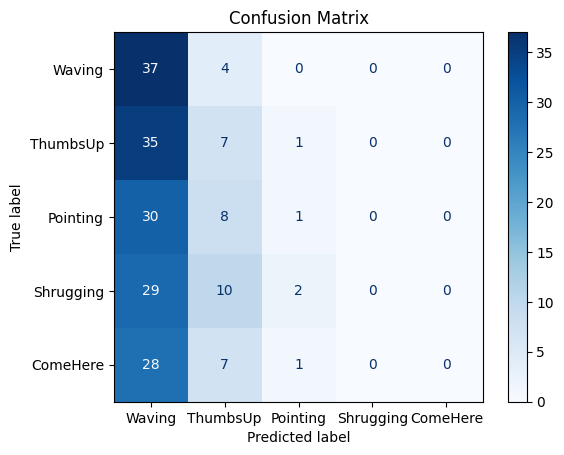

In [149]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Function to evaluate the model and compute additional metrics
def evaluate_model_with_metrics(model, test_loader, class_names):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to the same device as the model
            outputs = model(inputs)

            # Use softmax to get probabilities if needed, or directly take max
            _, predicted = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predicted.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Print classification report (precision, recall, F1-score)
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return cm

if __name__ == "__main__":
    # Load the best model
    model = RefinedConvLSTMModel(input_dim=3, hidden_dim=256, num_layers=2, output_dim=5, dropout_prob=0.3).to(device)
    model.load_state_dict(torch.load("best_model.pth"))

    # Define your test data (ensure it's defined)
    X_test = torch.randn(200, 10, 3)  # Example test data
    y_test = torch.randint(0, 5, (200,))  # Example test labels

    # Create test dataset and loader
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Evaluate the model
    class_names = ["Waving", "ThumbsUp", "Pointing", "Shrugging", "ComeHere"]
    evaluate_model_with_metrics(model, test_loader, class_names)
